In [1]:
"""Reference: https://github.com/nagypeterjob/Sentiment-Analysis-NLTK-ML-LSTM/blob/master/lstm.ipynb"""

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNLSTM, CuDNNGRU, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


Only keeping the needed columns.

In [2]:
train_data = pd.read_csv('../data/sentiment140_train.zip', encoding='ISO-8859-1', header=None, names=['sentiment','id','timestamp','type','user','text'])
test_data = pd.read_csv('../data/sentiment140_test.zip', encoding='ISO-8859-1', header=None, names=['sentiment','id','timestamp','type','user','text'])

# The original training data are sorted by sentiment value. Shuffle the training data for randomness
train_data = train_data[['text','sentiment']].sample(frac=1, random_state=40)
test_data = test_data[['text','sentiment']]

In [3]:
def canonicalize_text(text):
    text = text.lower()
    # Normalize the empty space symbol
    text = re.sub('[\t\n]', ' ', text)
    # Eliminate non-alphanumeric characters
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    # Replace all digits by symbol `DG`
    text = re.sub('\d+', 'DG', text)
    return text

def preprocess(data):
    data['text'] = data['text'].apply(canonicalize_text)

preprocess(train_data)
preprocess(test_data)

In [4]:
train_data.dtypes

text         object
sentiment     int64
dtype: object

In [5]:
train_data.head(10)

,text,sentiment
551218,i dont want to leave,0
1512535,good nite all sleep tight dont let the bed bug...,4
1295295,its a beautiful day guess whos going to see uD...,4
893979,yay for ikea swedish meatballs,4
279338,and god knows how many more singstar and buzz ...,0
886145,rosie_edward thanks you so much for following ...,4
1504955,good morning all hope ur day started well,4
728643,so bored weekend is almost over,0
1005200,carlaloo jajanika found our entry woohoo check...,4
1148569,ooh look who seems to be working tonight way t...,4


In [6]:
train_data['sentiment'].unique()

array([0, 4])

In [7]:
def get_corpus_vocabulary(df):
    vocabulary = Counter()
    for _, row in df.iterrows():
        words = row['text'].split()
        for word in words:
            vocabulary[word] += 1
    return vocabulary

vocabulary = get_corpus_vocabulary(train_data)

Plot the word count histogram of the training data

[1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 8, 9, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 22, 24, 26, 28, 30, 33, 35, 38, 41, 44, 47, 51, 55, 59, 63, 68, 73, 78, 83, 89, 95, 102, 109, 117, 125, 134, 143, 154, 167, 180, 194, 210, 227, 245, 265, 287, 310, 335, 363, 392, 426, 464, 506, 554, 608, 668, 736, 815, 906, 1011, 1133, 1277, 1445, 1643, 1878, 2163, 2508, 2930, 3459, 4132, 5006, 6160, 7727, 9966, 13383, 18923, 28375, 45063, 75112, 129493, 223083, 402773, 611300, 819826]


<BarContainer object of 100 artists>

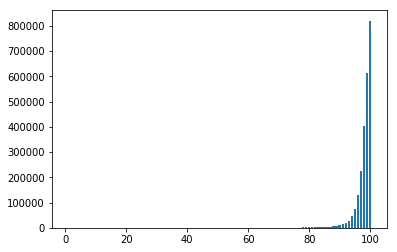

In [8]:
corpus_total_cnt = sum(vocabulary.values())
sorted_by_wd_cnt = sorted(((cnt, wd) for wd, cnt in vocabulary.items()), reverse=True)

plt_points = []
accu = 0
j = 0
for i in range(1, 101):
    while accu < (corpus_total_cnt * i / 100.0):
        accu += sorted_by_wd_cnt[j][0]
        j += 1
    plt_points.append(j)
    
print(plt_points)
plt.bar(range(1, 101), plt_points)

The top 10000 words account for 90% word occurance of the entire corpus.

In [9]:
print('The size of the training corpus: {}'.format(len(vocabulary)))
print('The top 10 words are: {}'.format(sorted_by_wd_cnt[:10]))
print('The least 10 words are: {}'.format(sorted_by_wd_cnt[-10:]))

The size of the training corpus: 819826
The top 10 words are: [(750807, 'i'), (564547, 'to'), (520035, 'the'), (377569, 'a'), (314054, 'my'), (298347, 'and'), (270065, 'you'), (236007, 'is'), (230839, 'it'), (215690, 'for')]
The least 10 words are: [(1, 'DG_DGmagazine'), (1, 'DG_DGchick'), (1, 'DG_DG_manytweets'), (1, 'DG_DG_hustle_ent'), (1, 'DG_'), (1, 'DG^o'), (1, 'DG^eDG'), (1, 'DG^c'), (1, 'DG^'), (1, 'DG\\quot')]


In [10]:
test_data.head(10)

,text,sentiment
0,stellargirl i loooooooovvvvvveee my kindleDG n...,4
1,reading my kindleDG love it lee childs is goo...,4
2,ok first assesment of the kindleDG it fucking ...,4
3,kenburbary youll love your kindleDG ive had mi...,4
4,mikefish fair enough but i have the kindleDG ...,4
5,richardebaker no it is too big im quite happy ...,4
6,fuck this economy i hate aig and their non loa...,0
7,jquery is my new best friend,4
8,loves twitter,4
9,how can you not love obama he makes jokes abou...,4


In [11]:
test_data['sentiment'].unique()

array([4, 0, 2])

Remove rows with neural sentiment score from the test data, since they don't exist in the train data

In [12]:
test_data = test_data[test_data['sentiment'].isin([0, 4])]
test_data['sentiment'].unique()

array([4, 0])

In [13]:
print('Positive rows: {}'.format(train_data[ train_data['sentiment'] == 4]['sentiment'].size))
print('Negative rows: {}'.format(train_data[ train_data['sentiment'] == 0]['sentiment'].size))

Positive rows: 800000
Negative rows: 800000


In [14]:
# Only keep top 10000 words in the corpus.
max_fatures = 10000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(train_data['text'].values)

In [15]:
X_train = tokenizer.texts_to_sequences(train_data['text'].values)
X_train = pad_sequences(X_train)

X_test = tokenizer.texts_to_sequences(test_data['text'].values)
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])

In [16]:
print('The shape of X_train: {}'.format(X_train.shape))
print('The shape of X_test: {}'.format(X_test.shape))

The shape of X_train: (1600000, 40)
The shape of X_test: (359, 40)


In [17]:
print(X_train[0])
print(X_test[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
  40  70   2 343]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    1    5   26   19    3
 9685    8  196   20    3   12    8 1010   11   25  485  112]


In [18]:
Y_train = pd.get_dummies(train_data['sentiment']).values
Y_test = pd.get_dummies(test_data['sentiment']).values
print('The shape of Y_train: {}'.format(Y_train.shape))
print('The shape of Y_test: {}'.format(Y_test.shape))

The shape of Y_train: (1600000, 2)
The shape of Y_test: (359, 2)


In [19]:
print(Y_train[:10])
print(Y_test[:10])

[[1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]]


In [20]:
size_limit = len(X_train)
X_train_sample, Y_train_sample = X_train[:size_limit], Y_train[:size_limit]

We should explore LSTM, CuDNNLSTM, GRU, CuDNNGRU cells. CuDNN cells have following limitations: 1. The activation function has to be `tanh`. 2. It doesn't support dropout.

In [21]:
def get_cudnn_lstm_model(input_length, max_fatures, embed_dim, lstm_out, dropout=0):
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim, input_length=input_length))
    
    # Given shape(x) = [samples, timesteps, channels], it uses noise_shape = [samples, 1, channels] and drops 
    # entire 1-D feature maps. Dropout matrix with this shape applies the same dropout rate at all timesteps.
    model.add(SpatialDropout1D(rate=dropout))
    # input dropout and recurrent dropout are not available for CuDNN celss
    model.add(CuDNNLSTM(lstm_out))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    print(model.summary())
    return model

def get_cudnn_gru_model(input_length, max_fatures, embed_dim, lstm_out, dropout=0):
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim, input_length=input_length))
    
    # Given shape(x) = [samples, timesteps, channels], it uses noise_shape = [samples, 1, channels] and drops 
    # entire 1-D feature maps. Dropout matrix with this shape applies the same dropout rate at all timesteps.
    model.add(SpatialDropout1D(rate=dropout))
    # input dropout and recurrent dropout are not available for CuDNN celss
    model.add(CuDNNGRU(lstm_out, return_sequences=True))
    model.add(CuDNNGRU(lstm_out))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    print(model.summary())
    return model

def get_cpu_model(input_length, max_fatures, embed_dim, lstm_out, input_dropout=0, recurrent_dropout=0):
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim, input_length=input_length))

    model.add(LSTM(lstm_out, dropout=input_dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    print(model.summary())
    return model

In [22]:
# Hyperparameters tuning for LSTM: https://arxiv.org/pdf/1707.06799.pdf
embed_dim = 200
lstm_out = 100
# Why 0.5: https://www.reddit.com/r/MachineLearning/comments/3oztvk/why_50_when_using_dropout/
# Variational Dropout: https://arxiv.org/pdf/1512.05287.pdf
input_dropout = 0.5
recurrent_dropout = 0.5

In [24]:
cudnn_lstm_model = get_cudnn_lstm_model(X_train.shape[1], max_fatures, embed_dim, lstm_out, input_dropout)

batch_size = 256
cudnn_lstm_model.fit(X_train_sample, Y_train_sample, epochs = 7, batch_size=batch_size, verbose = 2)

score, acc = cudnn_lstm_model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

cudnn_lstm_model.save('../models/cudnn_lstm_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 40, 200)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 100)               120800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 2,121,002
Trainable params: 2,121,002
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/7
 - 150s - loss: 0.4227 - acc: 0.8045
Epoch 2/7
 - 115s - loss: 0.3906 - acc: 0.8227
Epoch 3/7
 - 115s - loss: 0.3769 - acc: 0.8302
Epoch 4/7
 - 115s - loss: 0.3667 - acc: 0.8356
Epoch 5/7
 - 115s - loss: 0.3587 - acc: 0.8396
Epoch 6/7
 - 115s - loss

In [96]:
batch_size = 256
cudnn_lstm_model.fit(X_train_sample, Y_train_sample, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
 - 431s - loss: 0.3807 - acc: 0.8286
Epoch 2/7
 - 432s - loss: 0.3647 - acc: 0.8366
Epoch 3/7
 - 432s - loss: 0.3522 - acc: 0.8432
Epoch 4/7
 - 432s - loss: 0.3421 - acc: 0.8482
Epoch 5/7
 - 432s - loss: 0.3335 - acc: 0.8525
Epoch 6/7
 - 432s - loss: 0.3264 - acc: 0.8563
Epoch 7/7
 - 431s - loss: 0.3207 - acc: 0.8592


Extracting a validation set, and measuring score and accuracy.

In [97]:
score, acc = cudnn_lstm_model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

score: 0.37152850
acc: 0.83286907


In [103]:
cudnn_gru_model = get_cudnn_gru_model(X_train.shape[1], max_fatures, embed_dim, lstm_out, input_dropout)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 40, 200)           0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 40, 500)           1053000   
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 500)               1503000   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1002      
Total params: 4,557,002
Trainable params: 4,557,002
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
batch_size = 256
cudnn_gru_model.fit(X_train_sample, Y_train_sample, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
 - 773s - loss: 0.4213 - acc: 0.8053
Epoch 2/7
 - 770s - loss: 0.3868 - acc: 0.8248
Epoch 3/7
 - 771s - loss: 0.3714 - acc: 0.8336
Epoch 4/7
 - 771s - loss: 0.3599 - acc: 0.8395
Epoch 5/7
 - 771s - loss: 0.3517 - acc: 0.8435
Epoch 6/7
 - 771s - loss: 0.3466 - acc: 0.8465
Epoch 7/7
 - 772s - loss: 0.3433 - acc: 0.8482


In [106]:
score, acc = cudnn_gru_model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

score: 0.39665206
acc: 0.81615599


To improve:
1. The model is suffering from overfitting. We should add more dropout layers and try other regularization methods.
2. Systematically search for the optimal combination of hyperparameters
3. Try pretrained embedding, bidirectional RNN, combination of word and character level embedding